# Clinic Staff Assignment Formulation（Only Staff Assignment model in project)

Consider 18 staff of 4 job positions: Receptionist*4, Doctor*4, Nurse*6, Cleaning Staff*4.

## Problem statement

Determine an assignment that ensures that minimize the staffing and supply costs. 

## Objective function

The objective function is to minimize the total staffing and supply costs while satisfying the jobs constraints.

$$
Min ({Staffing Cost} {+} {Supply Cost} )
$$


## Decision variables

The decision variable $x_{h,\; i,\; j,\; k,\;} = 1$ represents that h,i is assigned to day j shift k, and 0 otherwise, for  h = {receptionist, doctor, nurse, cleaning_staff} and i = 1,2,3,4,5,6, 𝑗=1,2,3,4,5,6,7, k = 1,2,3

The decision variable $y_{h,\; i,\; j,\;} = 1$ represents that h,i is assigned to day j, and 0 otherwise, for  h = {receptionist, doctor, nurse, cleaning_staff} and i = 1,2,3,4,5,6, 𝑗=1,2,3,4,5,6,7

## Constraints

1.	Minimum staff for each shift should fulfill minimum request. 
2.	Decision variables should be binary decision. 
3.	Scheduling hour should be less than individual willingness. 
4.	No consecutive night-day or day-night shift. 
5.	Minimize staff number per day. 


## Python Coding

In [171]:
from gurobipy import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [173]:
# Step1: Set up basic information: employee, costday, costnight, minimum request, supply

employee = ['reception', 'doctor', 'nurse', 'cleaningstaff']
willingness = {}
for h in employee:
    for i in range (1,7):
        for j in range (1,8):
            if (h == 'reception' or h == 'doctor' or h == 'cleaningstaff') and i > 4:
                willingness[(h,i,j)] = 0
            elif j == 7 :
                willingness[(h,i,j)] = 3
            else:
                willingness[(h,i,j)] = 6

costday = {'reception': 30,
          'doctor': 50,
          'nurse':40,
          'cleaningstaff':20}

costnight = {'reception': 35,
          'doctor': 9999,
          'nurse':45,
          'cleaningstaff':55}

# min request should be the outcome from Customer Estimation model, here we simply input as an constant

minimum_request = {'reception':[2,1,1,1,2,0,2,1,1,2,2,0,2,2,1,2,2,0,0,0,1], 
                   'doctor':[1,1,0,1,2,0,1,1,0,1,2,0,1,2,0,2,2,0,0,0,0],
                   'nurse': [1,2,2,2,3,0,2,2,2,2,3,0,2,3,2,3,3,0,0,0,0], 
                   'cleaningstaff':[1,2,1,1,2,0,1,2,1,1,2,0,2,2,1,2,2,0,0,0,0]}
required = {}
for h in employee:
    l = 0
    for j in range(1,8):
        for k in range(1,4):
            required[(h,j,k)] = minimum_request[h][l]
            l = l+1   

supply = {'mask': 1,
         'gloves':2,
         'sanitized suit':20}

In [175]:
#Set up the gurobi model
Model = gurobipy.Model("Work Schedule")

In [176]:
#Add Variable Xhijk
x = Model.addVars(employee,range (1,7),range(1,8),range(1,4),vtype = gurobipy.GRB.BINARY, name="assign")

In [177]:
#Add Variable Yhijk
y = Model.addVars(employee,range (1,7),range(1,8), vtype = gurobipy.GRB.BINARY, name="assignday")

In [179]:
#Set up the objective function: Min ((Staffing Cost) + (Supply Cost))
Model.setObjective(gurobipy.quicksum(x[h,i,j,k]*costday[h]*3+x[h,i,j,3]*costnight[h]*3 +x[h,i,j,k]*3+y[h,i,j]*20 for h in employee for i in range(1,7) for j in range(1,8) for k in range (1,3)),sense = gurobipy.GRB.MINIMIZE)

In [180]:
#Add Constraint#1: Minimum staff for each shift should fulfill minimum request.
Model.addConstrs(x.sum(h,'*',j,k) >= required [(h,j,k)] for h in employee for k in range(1,4) for j in range(1,8))
Model.update()

In [181]:
#Add Constraint#3: Scheduling hour should less than individual willingness. 
Model.addConstrs(x.sum(h,i,j,'*')*3 <= willingness[(h,i,j)] for h in employee for i in range(1,7) for j in range(1,8))
Model.update()

In [182]:
#Add Constraint#4: No consecutive night-day or day-night shift. 
Model.addConstrs(x[h,i,j,3] + x[h,i,(j+1),1] <= 1 for h in employee for i in range(1,7) for j in range(1,7))
Model.update()

In [183]:
#Add Constraint#5: Minimize staff number per day. 
Model.addConstrs(x[h,i,j,1] <= y[h,i,j] for h in employee for i in range(1,7) for j in range(1,8))
Model.update()

In [184]:
#Add Constraint#5: Minimize staff number per day. 
Model.addConstrs(x[h,i,j,2] <= y[h,i,j] for h in employee for i in range(1,7) for j in range(1,8))
Model.update()

In [185]:
#Add Constraint#5: Minimize staff number per day. 
Model.addConstrs(x[h,i,j,3] <= y[h,i,j] for h in employee for i in range(1,7) for j in range(1,8))
Model.update()

In [186]:
#optimize
Model.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 900 rows, 672 columns and 2304 nonzeros
Model fingerprint: 0xc5587b32
Variable types: 0 continuous, 672 integer (672 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [4e+01, 6e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 15508.000000
Presolve removed 853 rows and 630 columns
Presolve time: 0.05s
Presolved: 47 rows, 42 columns, 120 nonzeros
Found heuristic solution: objective 14988.000000
Variable types: 0 continuous, 42 integer (42 binary)

Root relaxation: objective 1.490800e+04, 38 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 14908.0000    0    8 14988.0000 14908.0000  0.53%     -    0s
H    0

In [191]:
# Convert the output into a list of lists
matrix = []
for v in Model.getVars():
#    print(v.varName, v.x)
    matrix.append(v.x)
matrix
i = 0
new = []
while i<(len(matrix)-168):
    new.append(matrix[i:i+21])
    i+=21
    

In [188]:
# Convert the result list of lists into array
staff = ["reception1", "reception2", "reception3", "reception4","reception5", "reception6", 
         "doctor1","doctor2","doctor3","doctor4","doctor5","doctor6",
        "nurse1","nurse2","nurse3","nurse4","nurse5","nurse6",
        "cleaningstaff1","cleaningstaff2","cleaningstaff3","cleaningstaff4","cleaningstaff5","cleaningstaff6"]

shift = ["Mon_s1", "Mon_s2", "Mon_s3",
         "Tue_s1", "Tue_s2", "Tue_s3",
         "Wed_s1", "Wed_s2", "Wed_s3",
         "Thu_s1", "Thu_s2", "Thu_s3",
         "Fri_s1", "Fri_s2", "Fri_s3",
         "Sat_s1", "Sat_s2", "Sat_s3",
         "Sun_s1", "Sun_s2", "Sun_s3"]

schedule = np.array(new)

In [189]:
#Adjust format and output the schedule
print('Assigments')
print('Symbols: \'-\': not working, \'S\': Scheduled')
a = pd.DataFrame(schedule, columns = shift)
a = a.replace(0, '-')
a = a.replace(1, 'S')
a['new_index'] = staff
a = a.set_index('new_index')
a = a.drop(['reception5', 'reception6','doctor5','doctor6','cleaningstaff5','cleaningstaff6'])
a = a.drop (['Tue_s3', 'Thu_s3','Sat_s3','Sun_s1','Sun_s2'], axis=1)
a

Assigments
Symbols: '-': not working, 'S': Scheduled


,Mon_s1,Mon_s2,Mon_s3,Tue_s1,Tue_s2,Wed_s1,Wed_s2,Wed_s3,Thu_s1,Thu_s2,Fri_s1,Fri_s2,Fri_s3,Sat_s1,Sat_s2,Sun_s3
new_index,,,,,,,,,,,,,,,,
reception1,S,-,S,-,-,S,-,S,-,-,S,S,-,-,-,-
reception2,-,-,-,-,-,-,-,-,-,-,-,-,S,-,-,-
reception3,-,-,-,-,S,-,-,-,S,S,-,-,-,S,S,-
reception4,S,S,-,S,S,S,S,-,S,S,S,S,-,S,S,S
doctor1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
doctor2,S,S,-,S,S,S,S,-,S,S,S,S,-,-,-,-
doctor3,-,-,-,-,S,-,-,-,-,S,-,S,-,S,S,-
doctor4,-,-,-,-,-,-,-,-,-,-,-,-,-,S,S,-
nurse1,S,S,-,-,-,S,-,S,-,-,-,S,S,-,-,-


<AxesSubplot:ylabel='new_index'>

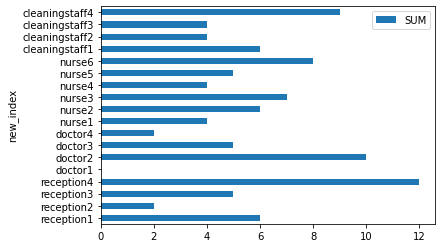

In [170]:
b = pd.DataFrame(schedule, columns = shift)
b['SUM'] = b.sum(axis=1)
b['new_index'] = staff
b = b.drop([4, 5, 10,11,22,23])
b.plot.barh(x='new_index', y='SUM', rot=0)